<a href="https://colab.research.google.com/github/Heaven-Bro/Decision-Tree-DT-Implementation-and-Comparison/blob/main/210152_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

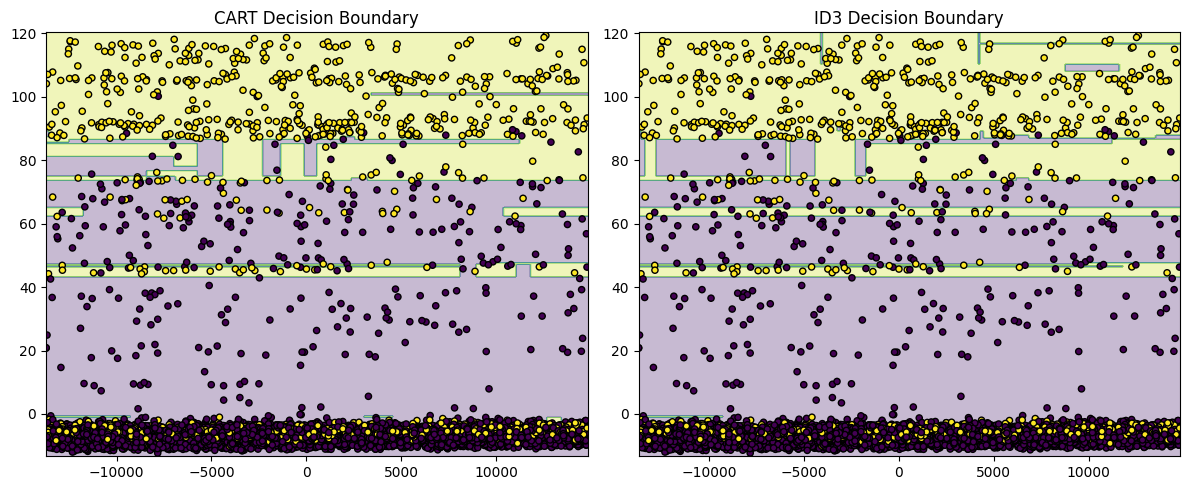

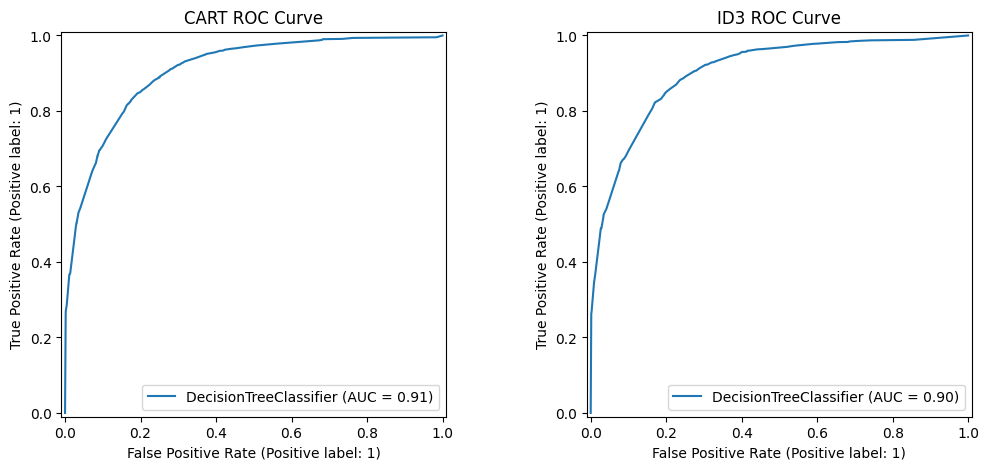

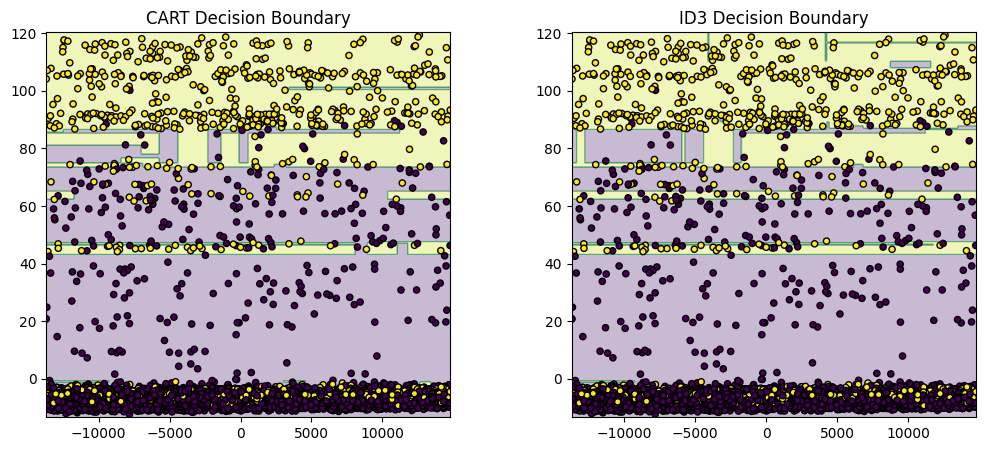

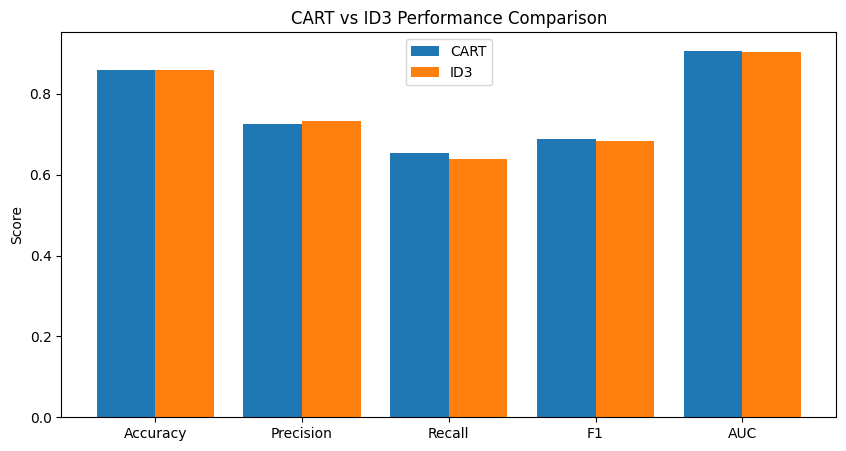

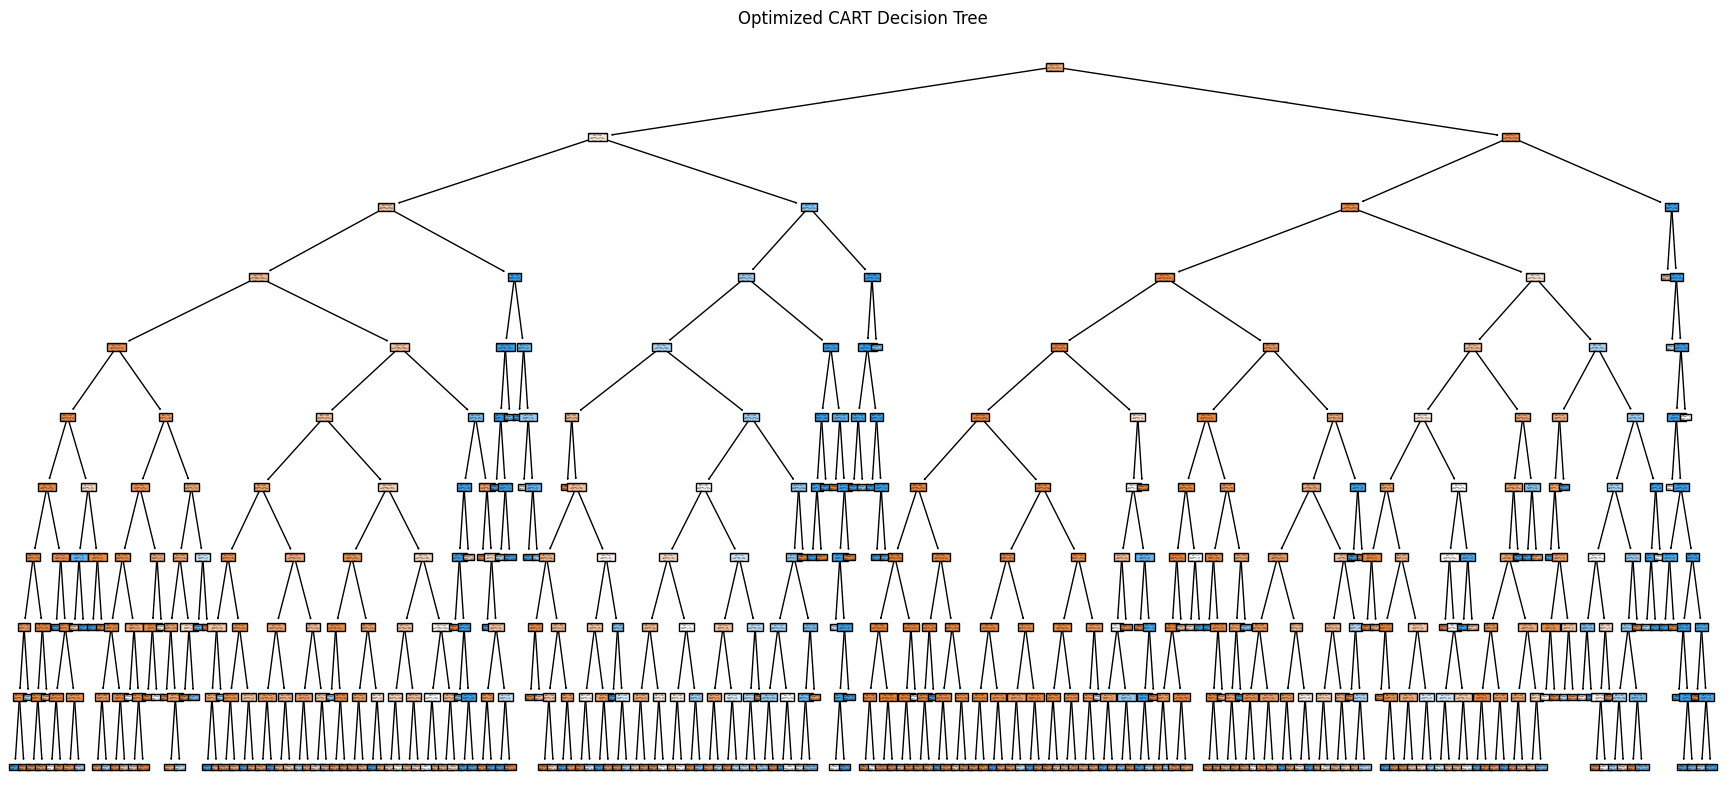

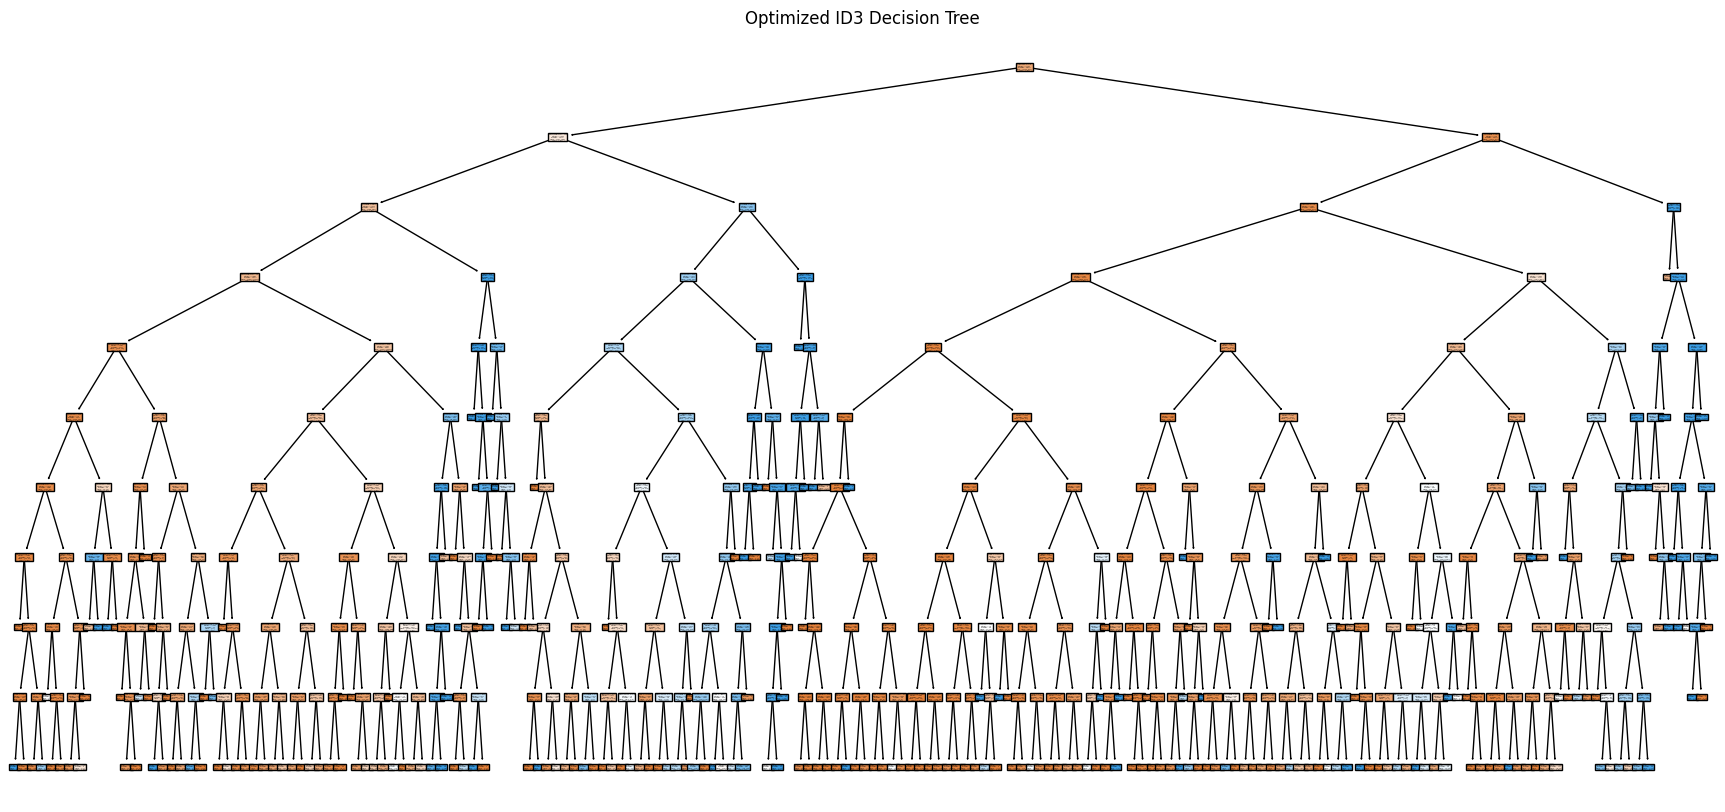

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.decomposition import PCA

DATA_URL = "https://raw.githubusercontent.com/Heaven-Bro/Decision-Tree-DT-Implementation-and-Comparison/main/adult.csv"
df = pd.read_csv(DATA_URL)

df.replace("?", np.nan, inplace=True)

target = "income"
X = df.drop(columns=[target])
y = df[target]

imputer = SimpleImputer(strategy="most_frequent")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col])

y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cart = DecisionTreeClassifier(criterion="gini", random_state=42)
cart_params = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20]
}
cart_cv = GridSearchCV(cart, cart_params, cv=5, scoring="accuracy", n_jobs=-1)
cart_cv.fit(X_train, y_train)
best_cart = cart_cv.best_estimator_

id3 = DecisionTreeClassifier(criterion="entropy", random_state=42)
id3_params = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20]
}
id3_cv = GridSearchCV(id3, id3_params, cv=5, scoring="accuracy", n_jobs=-1)
id3_cv.fit(X_train, y_train)
best_id3 = id3_cv.best_estimator_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

cart_pca = DecisionTreeClassifier(**best_cart.get_params())
id3_pca = DecisionTreeClassifier(**best_id3.get_params())

cart_pca.fit(X_train_pca, y_train_pca)
id3_pca.fit(X_train_pca, y_train_pca)

def plot_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=20)
    plt.title(title)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_boundary(cart_pca, X_test_pca, y_test_pca, "CART Decision Boundary")
plt.subplot(1,2,2)
plot_boundary(id3_pca, X_test_pca, y_test_pca, "ID3 Decision Boundary")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,5))
RocCurveDisplay.from_estimator(best_cart, X_test, y_test, ax=ax[0])
ax[0].set_title("CART ROC Curve")
RocCurveDisplay.from_estimator(best_id3, X_test, y_test, ax=ax[1])
ax[1].set_title("ID3 ROC Curve")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_boundary(cart_pca, X_test_pca, y_test_pca, "CART Decision Boundary")
plt.subplot(1,2,2)
plot_boundary(id3_pca, X_test_pca, y_test_pca, "ID3 Decision Boundary")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()


def metrics(model):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    return [
        round(accuracy_score(y_test, y_pred), 3),
        round(precision_score(y_test, y_pred), 3),
        round(recall_score(y_test, y_pred), 3),
        round(f1_score(y_test, y_pred), 3),
        round(roc_auc_score(y_test, y_prob), 3)
    ]

cart_scores = metrics(best_cart)
id3_scores = metrics(best_id3)

labels = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
x = np.arange(len(labels))

plt.figure(figsize=(10,5))
plt.bar(x-0.2, cart_scores, width=0.4, label="CART")
plt.bar(x+0.2, id3_scores, width=0.4, label="ID3")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("CART vs ID3 Performance Comparison")
plt.legend()
plt.show()


plt.figure(figsize=(22,10))
plot_tree(
    best_cart,
    feature_names=X.columns,
    class_names=["<=50K", ">50K"],
    filled=True
)
plt.title("Optimized CART Decision Tree")
plt.show()

plt.figure(figsize=(22,10))
plot_tree(
    best_id3,
    feature_names=X.columns,
    class_names=["<=50K", ">50K"],
    filled=True
)
plt.title("Optimized ID3 Decision Tree")
plt.show()
